<a href="https://colab.research.google.com/github/Abbta/adlfpae/blob/main/Exercise_8_3_RNN_engine_lifetime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#8.1 Engine lifetime with RNNs

In this exercise, you will develop a Recurrent Neural Network capable of estimating the lifetime of engines. Your final submission should include a link to your google collab notebook, and a pdf adressing the questions asked in the task. You can use this template to get started: https://colab.research.google.com/drive/1HeCd0EIGTEbAAVNgyWeMKMgCejKcA031#scrollTo=A_dA-aOjvbza

The paper that can help you with the exercises can be found here:\
Wang, Y., Zhao, Y. & Addepalli, S. Practical Options for Adopting Recurrent Neural Network and Its Variants on Remaining Useful Life Prediction. Chin. J. Mech. Eng. 34, 69 (2021). https://doi.org/10.1186/s10033-021-00588-x

##Experimental Scenario

The data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. Therefore, the labels for the training data set have to be determined from the remaining time steps. In the test set, the time series ends some time prior to system failure. The objective of the exercise is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided is a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1\.	unit number\
2\.	time, in cycles\
3\.	operational setting 1\
4\.	operational setting 2\
5\.	operational setting 3\
6\.	sensor measurement  1\
7\.	sensor measurement  2\
... \
26\.	sensor measurement  21

For this exercise we only consider the FD001 data set.

Data Set: FD001\
Train trjectories: 100\
Test trajectories: 100\
Conditions: ONE (Sea Level)\
Fault Modes: ONE (HPC Degradation)




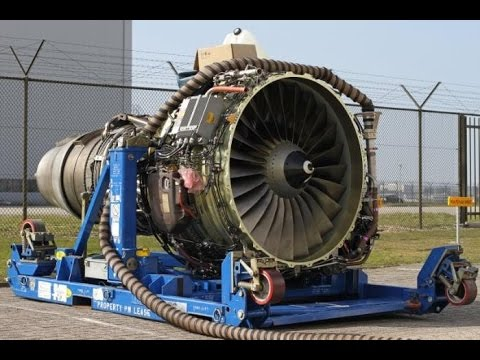



Y. Dwivedi, Predicting Engine Failure using C-MAPSS data, 2018 (https://yajasd.github.io/2018/06/04/Predicting-Engine-Failure/)

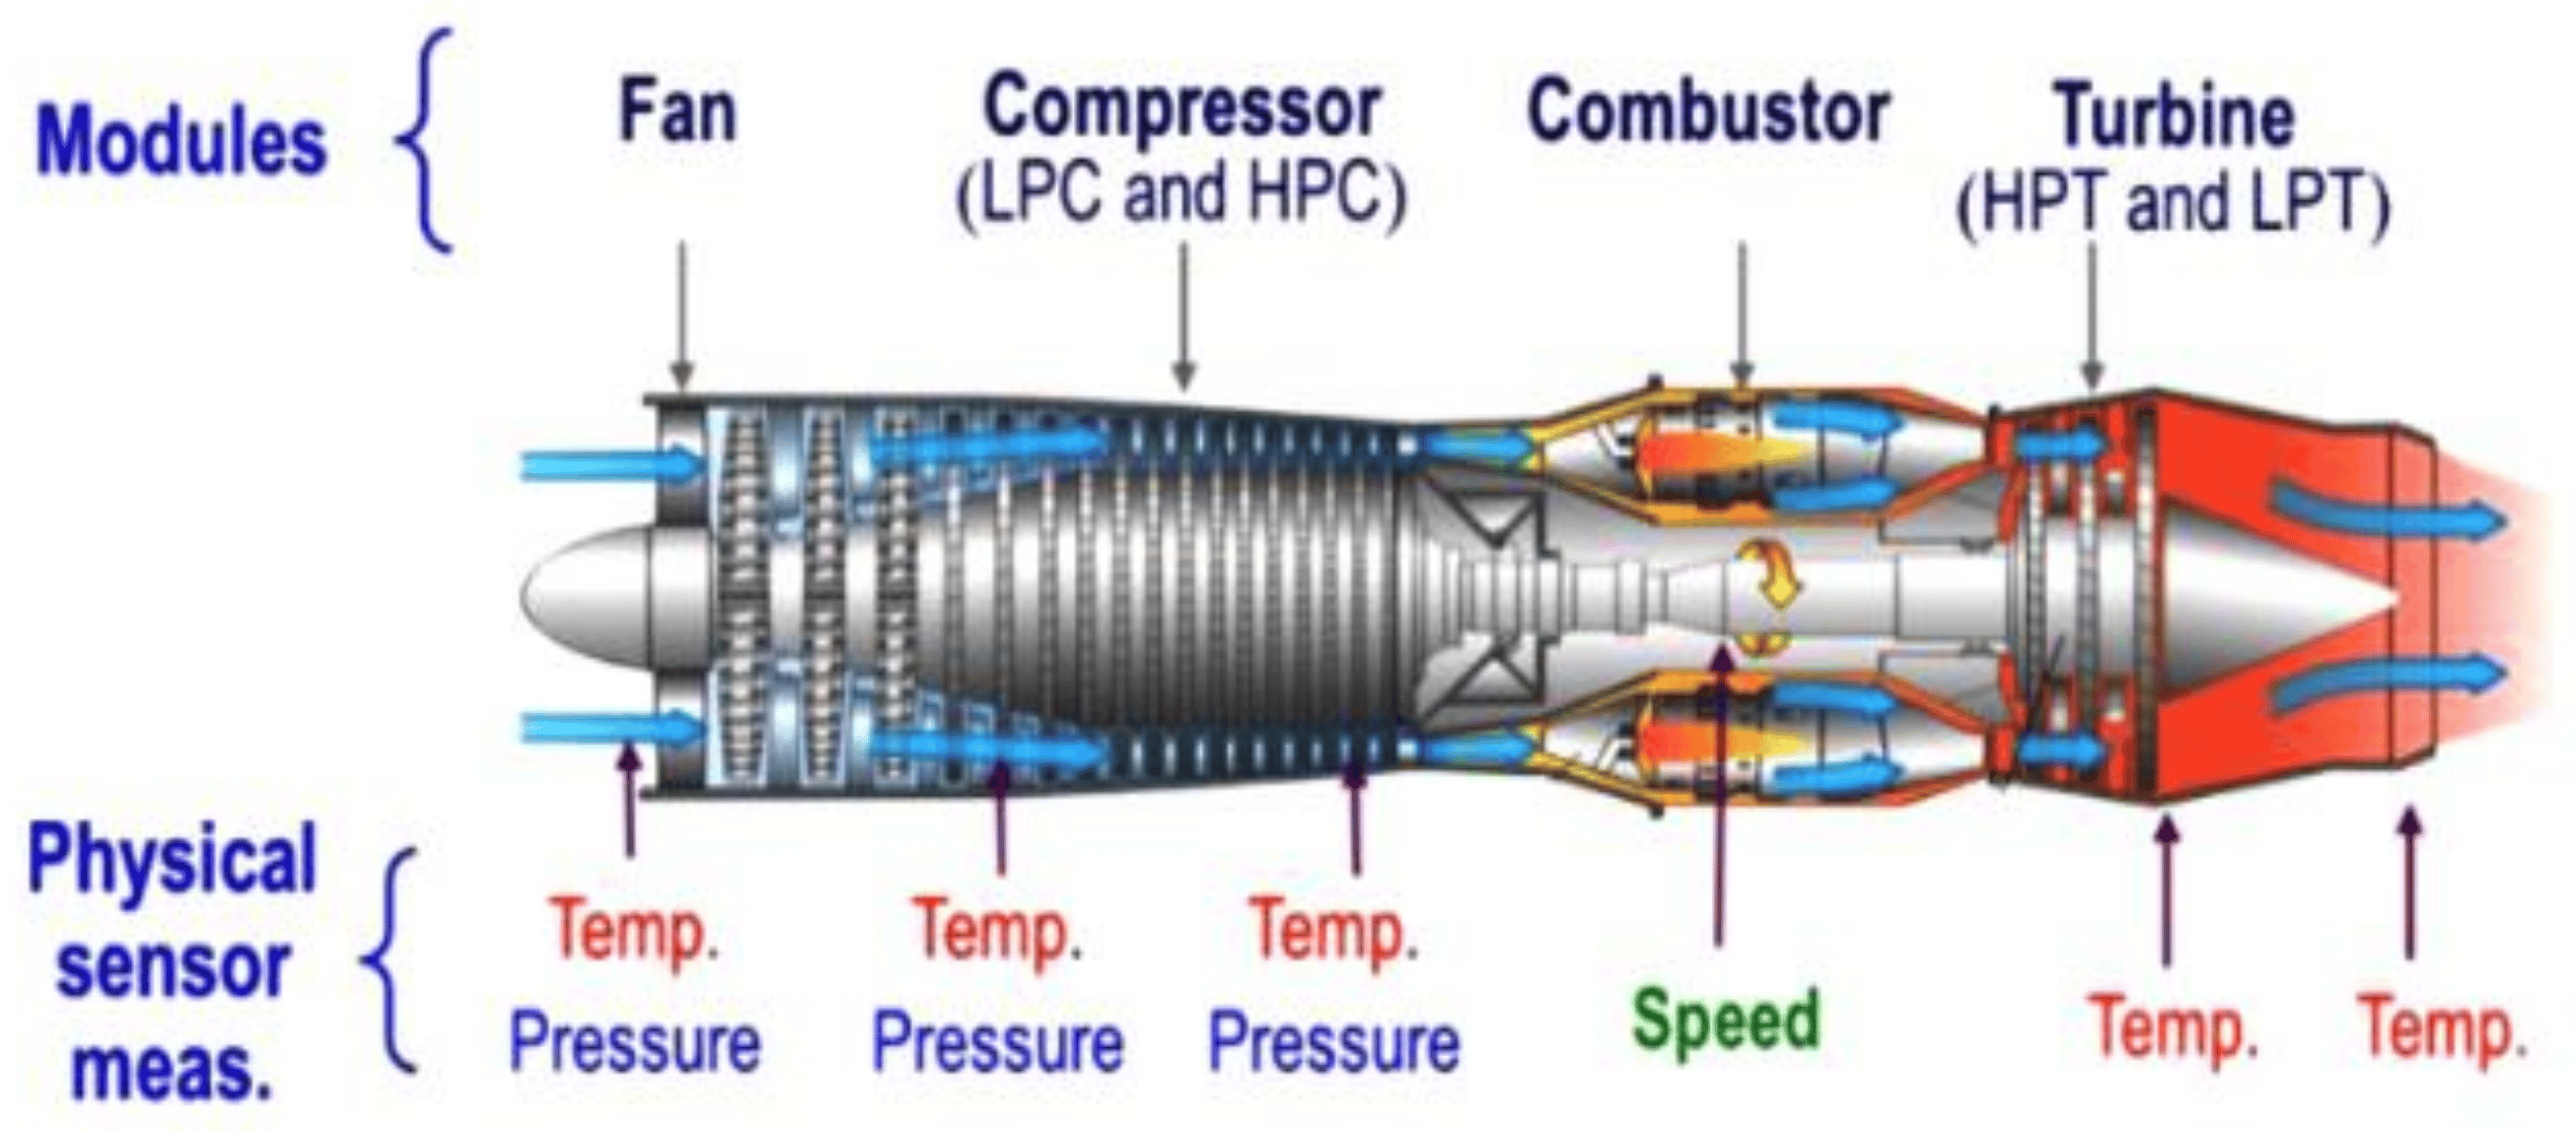


Muneer, A.; Taib, S.M.; Naseer, S.; Ali, R.F.; Aziz, I.A. Data-Driven Deep Learning-Based Attention Mechanism for Remaining Useful Life Prediction: Case Study Application to Turbofan Engine Analysis. Electronics 2021, 10, 2453. https://doi.org/10.3390/electronics10202453

## Exercises

The data structure of the input data is the most important thing when training a RNN. Make sure you understand the format of the input data.


1.   Normalize the input data. It can be useful to use helper functions instead of manually implementing the normaliztion. Here, you get to know the `sklearn` package. Please use the functions `sklearn.preprocessing.StandardScaler().fit()` and `sklearn.preprocessing.StandardScaler().transform()`. For additional help see the documentation (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and this tutorial (https://www.youtube.com/watch?v=ZddUwo4R5ug).

2.   Make several plots to understand the input data for all, and for a single unit. How do the plots change after the normalization? Also plot the labels for the training data.

3.   Explain in your notes what the for-loop in section 10 is doing and why it is important. Is there an optimal value for n_past? Try to find it. Hint: Consider the input dimensions for the test data set.

4.   Set up your RNN in section 13 using `keras.layers.LSTM()`. Think about what dimension the final dense layer should have.

5.   Set up the `model.fit` function in section 14 and train your RNN model. Test different callback options. What do you notice during training? Write down your reflections and what thoughts went into your final training strategy.

6.   Plot the training and validation loss against training epochs.

7.   Apply the trained model to both, the trainning data set, and the test data set.

8.   Make several plots to evaluate the trained model. Start with a plot where you compare the training data labels to the predictions your final model makes for the training data set. For the test data, plot the predictions and the true values for each unit. In a second figure, plot the residuals of your predictions as a histogram.

9.   Use the MSE function to break down the performance of your model to a single number.

10.   If you want to be 95% sure that the engine still has at least 20 cycles to go, at what network output should you recommend maintenance? (The histogram with the residuals can help you with your estimate.)



## 1) Importing relevant libraries

In [1]:
# you don't have to touch this
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

layers = keras.layers
models = keras.models

print(keras.__version__)
print(pd.__version__)

3.5.0
2.2.2


## 2) Downloading the Data

In [2]:
#downloading the data set
# you don't have to touch this
if os.path.exists("application%2Fzip") == False:
  !wget https://data.nasa.gov/download/ff5v-kuh6/application%2Fzip
  !unzip application%2Fzip

--2024-12-06 21:12:24--  https://data.nasa.gov/download/ff5v-kuh6/application%2Fzip
Resolving data.nasa.gov (data.nasa.gov)... 128.102.186.77, 2001:4d0:6311:2c05:60b0:5ad8:1210:ea07
Connecting to data.nasa.gov (data.nasa.gov)|128.102.186.77|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.nasa.gov/api/views/ff5v-kuh6/files/680c0016-00ca-47a5-a4b9-e6c9437f8409?filename=CMAPSSData.zip [following]
--2024-12-06 21:12:25--  https://data.nasa.gov/api/views/ff5v-kuh6/files/680c0016-00ca-47a5-a4b9-e6c9437f8409?filename=CMAPSSData.zip
Reusing existing connection to data.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘application%2Fzip’

application%2Fzip       [       <=>          ]  11.85M  6.46MB/s    in 1.8s    

2024-12-06 21:12:28 (6.46 MB/s) - ‘application%2Fzip’ saved [12425978]

Archive:  application%2Fzip
  inflating: Damage Propagation Modeling.pdf  
  inflating: readme.t

## 3) Preparing the training data

In [3]:
#training data set without labels
# you don't have to touch this

data_train = pd.read_csv('train_FD001.txt', delimiter=' ', header=None)
number_of_sensors = 21

name_list = ['unit', 'time', 'setting0', 'setting1', 'setting2']
for i in range(number_of_sensors):
  name_list.append('sensor'+str(i))

name_list.append('empty1')
name_list.append('empty2')
data_train.columns = name_list
data_train = data_train.drop(['empty1'], axis=1)
data_train = data_train.drop(['empty2'], axis=1)


##4) Plot the data for all units

In [4]:
print(data_train.head)

<bound method NDFrame.head of        unit  time  setting0  setting1  setting2  sensor0  sensor1  sensor2  \
0         1     1   -0.0007   -0.0004     100.0   518.67   641.82  1589.70   
1         1     2    0.0019   -0.0003     100.0   518.67   642.15  1591.82   
2         1     3   -0.0043    0.0003     100.0   518.67   642.35  1587.99   
3         1     4    0.0007    0.0000     100.0   518.67   642.35  1582.79   
4         1     5   -0.0019   -0.0002     100.0   518.67   642.37  1582.85   
...     ...   ...       ...       ...       ...      ...      ...      ...   
20626   100   196   -0.0004   -0.0003     100.0   518.67   643.49  1597.98   
20627   100   197   -0.0016   -0.0005     100.0   518.67   643.54  1604.50   
20628   100   198    0.0004    0.0000     100.0   518.67   643.42  1602.46   
20629   100   199   -0.0011    0.0003     100.0   518.67   643.23  1605.26   
20630   100   200   -0.0032   -0.0005     100.0   518.67   643.85  1600.38   

       sensor3  sensor4  ...  sen

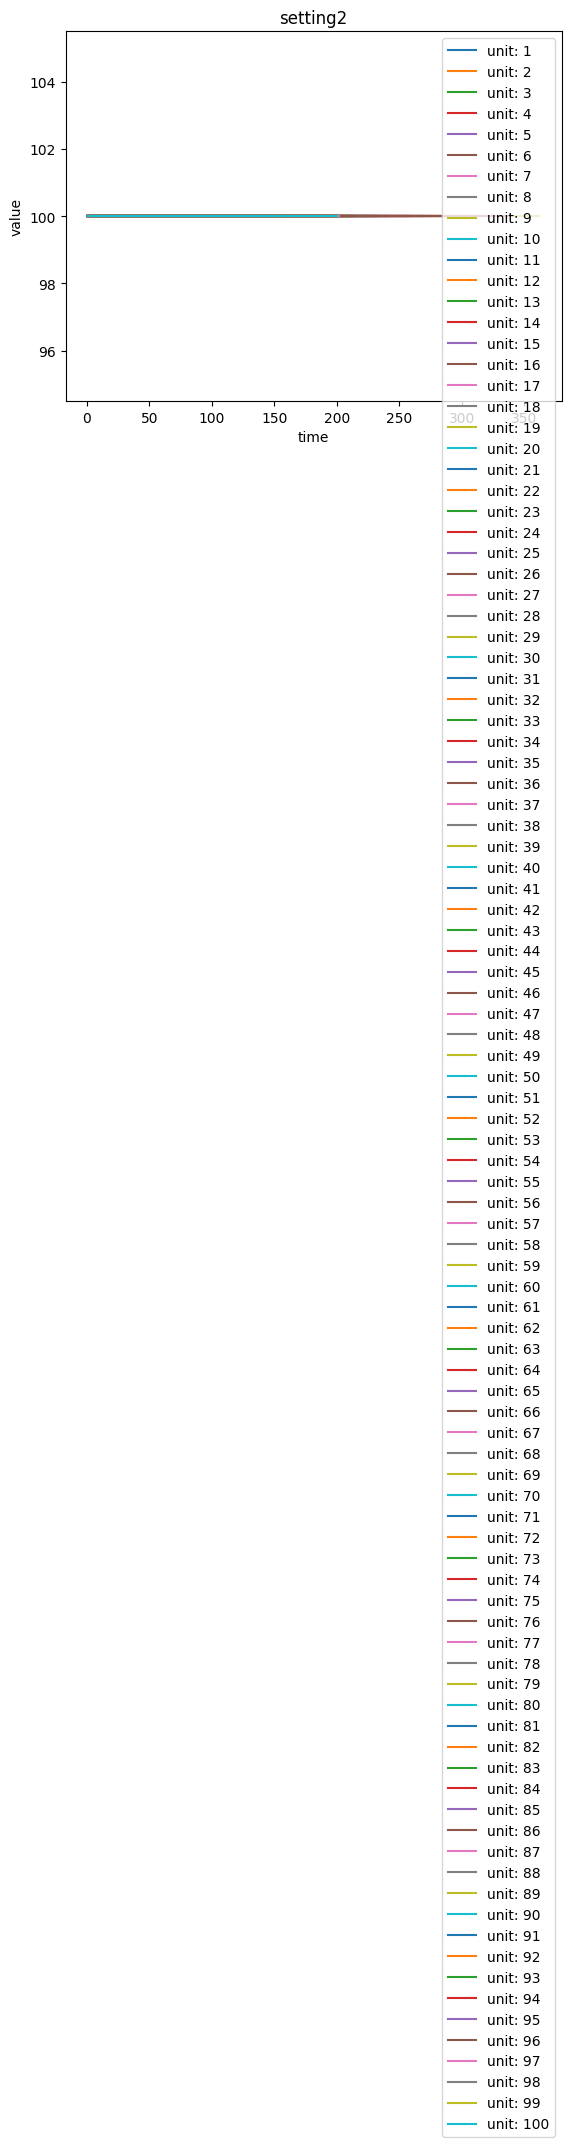

In [ ]:
#plot the input data for all units

ax=plt.subplot()
num_units=data_train["unit"].nunique()
num_plot=num_units #How many units to plot

sensor_to_plot="setting2"

for unit in range(1, num_plot+1):
  data_train[data_train["unit"]==unit].plot("time", sensor_to_plot, ax=ax, label=f"unit: {unit}", title=f"{sensor_to_plot}", ylabel="value")


##5) Plot the data for a single unit

<ipython-input-14-a26427ee0d5d>:16: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


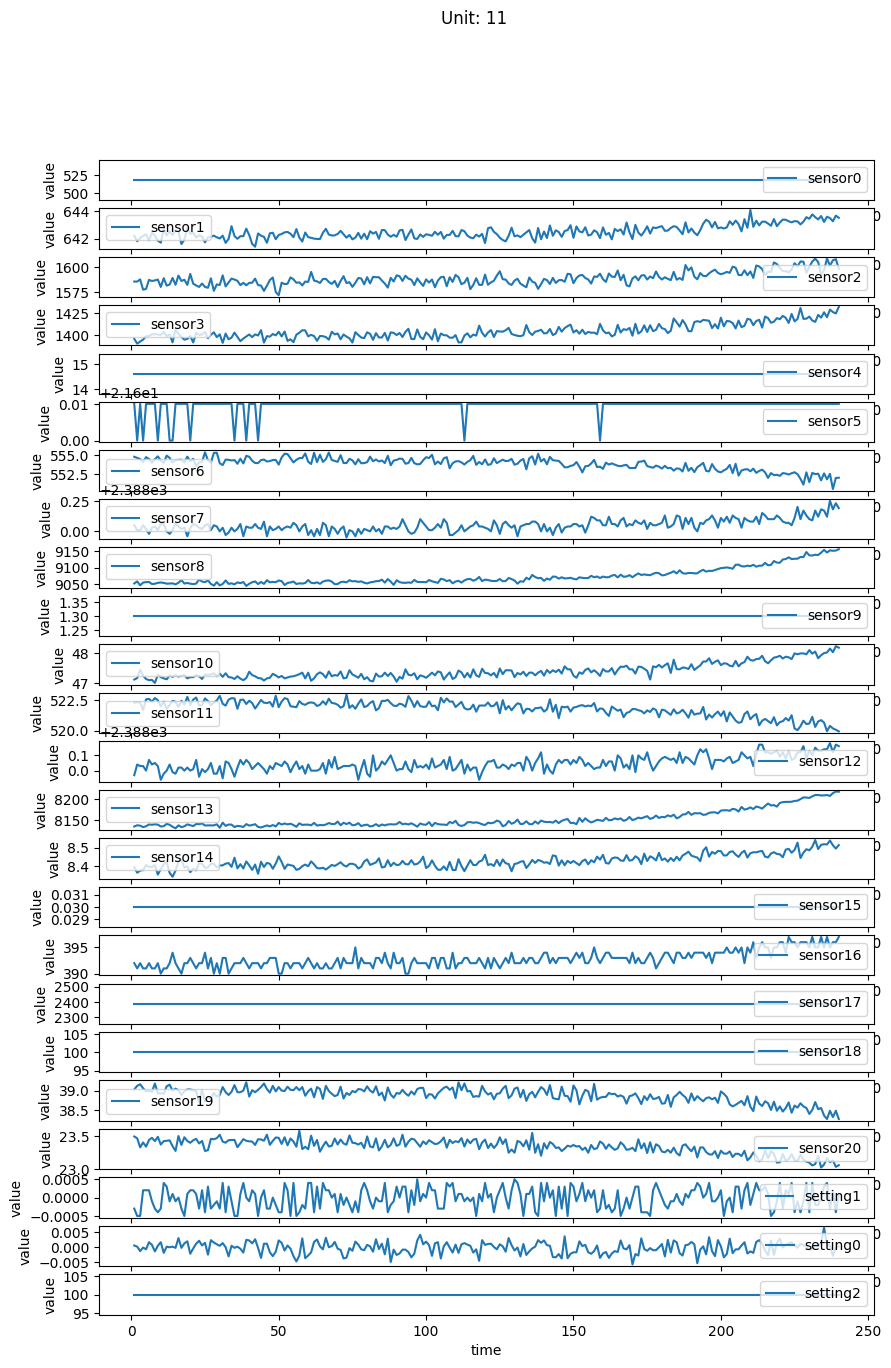

In [ ]:
#plot the input data for one unit

num_plot=number_of_sensors #Plot for some sensors
fig, ax=plt.subplots(3+num_plot, figsize=(10,15))


unit_to_plot=11

for sensor in range(0, num_plot):
    data_train[data_train["unit"]==unit_to_plot].plot("time", f"sensor{sensor}", ax=ax[sensor], label=f"sensor{sensor}", ylabel="value")

data_train[data_train["unit"]==unit_to_plot].plot("time", "setting1", ax=ax[-3], label=f"setting1", ylabel="value")
data_train[data_train["unit"]==unit_to_plot].plot("time", "setting0", ax=ax[-2], label=f"setting0", ylabel="value")
data_train[data_train["unit"]==unit_to_plot].plot("time", "setting2", ax=ax[-1], label=f"setting2", ylabel="value")
fig.suptitle(f"Unit: {unit_to_plot}")
fig.tight_layout()



Setting 2 aswell as sensor 0, 4, 5, 9, 15, 17 and 18 are all constant over all units (Some noice in sensor 5). These columns contain no valuable information for this problem.

##6) Drop irrelevant columns and normalize the training data

In [4]:
#training data set without labels

data_train = pd.read_csv('train_FD001.txt', delimiter=' ', header=None)
number_of_sensors = 21

name_list = ['unit', 'time', 'setting0', 'setting1', 'setting2']
for i in range(number_of_sensors):
  name_list.append('sensor'+str(i))

name_list.append('empty1')
name_list.append('empty2')
data_train.columns = name_list
data_train = data_train.drop(['empty1'], axis=1)
data_train = data_train.drop(['empty2'], axis=1)

#choose which columns of data you want to keep and which you want to drop.
#Training with everything works but might not be the best choice.

#Drop columns with no correlation to result
data_train=data_train.drop(["setting2", "sensor0", "sensor4", "sensor5", "sensor9", "sensor15", "sensor17", "sensor18"], axis=1)

#normalization of the training, don't normalize time and unit!
data_train_scaled=data_train.drop(["unit", "time"], axis=1)
#Note that normalization is done over the whole dataset, not unit wise
scaler=StandardScaler().fit(data_train_scaled)
data_train_scaled = pd.DataFrame(scaler.transform(data_train_scaled), columns=scaler.feature_names_in_)
#Readd time and unit (for plotting)
data_train_scaled=pd.concat([data_train[["unit", "time"]], data_train_scaled], axis=1)

In [ ]:
data_train_scaled.head()

,unit,time,setting0,setting1,sensor1,sensor2,sensor3,sensor6,sensor7,sensor8,sensor10,sensor11,sensor12,sensor13,sensor14,sensor16,sensor19,sensor20
0,1,1,-0.315980,-1.372953,-1.721725,-0.134255,-0.925936,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427
1,1,2,0.872722,-1.031720,-1.061780,0.211528,-0.643726,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.781710,1.016528,1.236922
2,1,3,-1.961874,1.015677,-0.661813,-0.413166,-0.525953,1.008155,-0.234584,-0.557139,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-2.073094,0.739891,0.503423
3,1,4,0.324090,-0.008022,-0.661813,-1.261314,-0.784831,1.222827,0.188048,-0.713826,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-0.781710,0.352598,0.777792
4,1,5,-0.864611,-0.690488,-0.621816,-1.251528,-0.301518,0.714393,-0.516338,-0.457059,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-0.136018,0.463253,1.059552


##7) Plot the normalized the training data for all units and a single unit

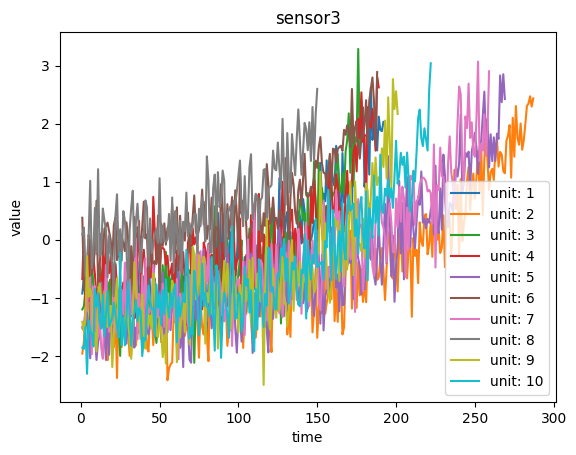

In [ ]:
#plot the input data for all units

ax=plt.subplot()
num_units=data_train_scaled["unit"].nunique()
num_plot=10 #How many units to plot

sensor_to_plot="sensor3"

for unit in range(1, num_plot+1):
  data_train_scaled[data_train_scaled["unit"]==unit].plot("time", sensor_to_plot, ax=ax, label=f"unit: {unit}", title=f"{sensor_to_plot}", ylabel="value")

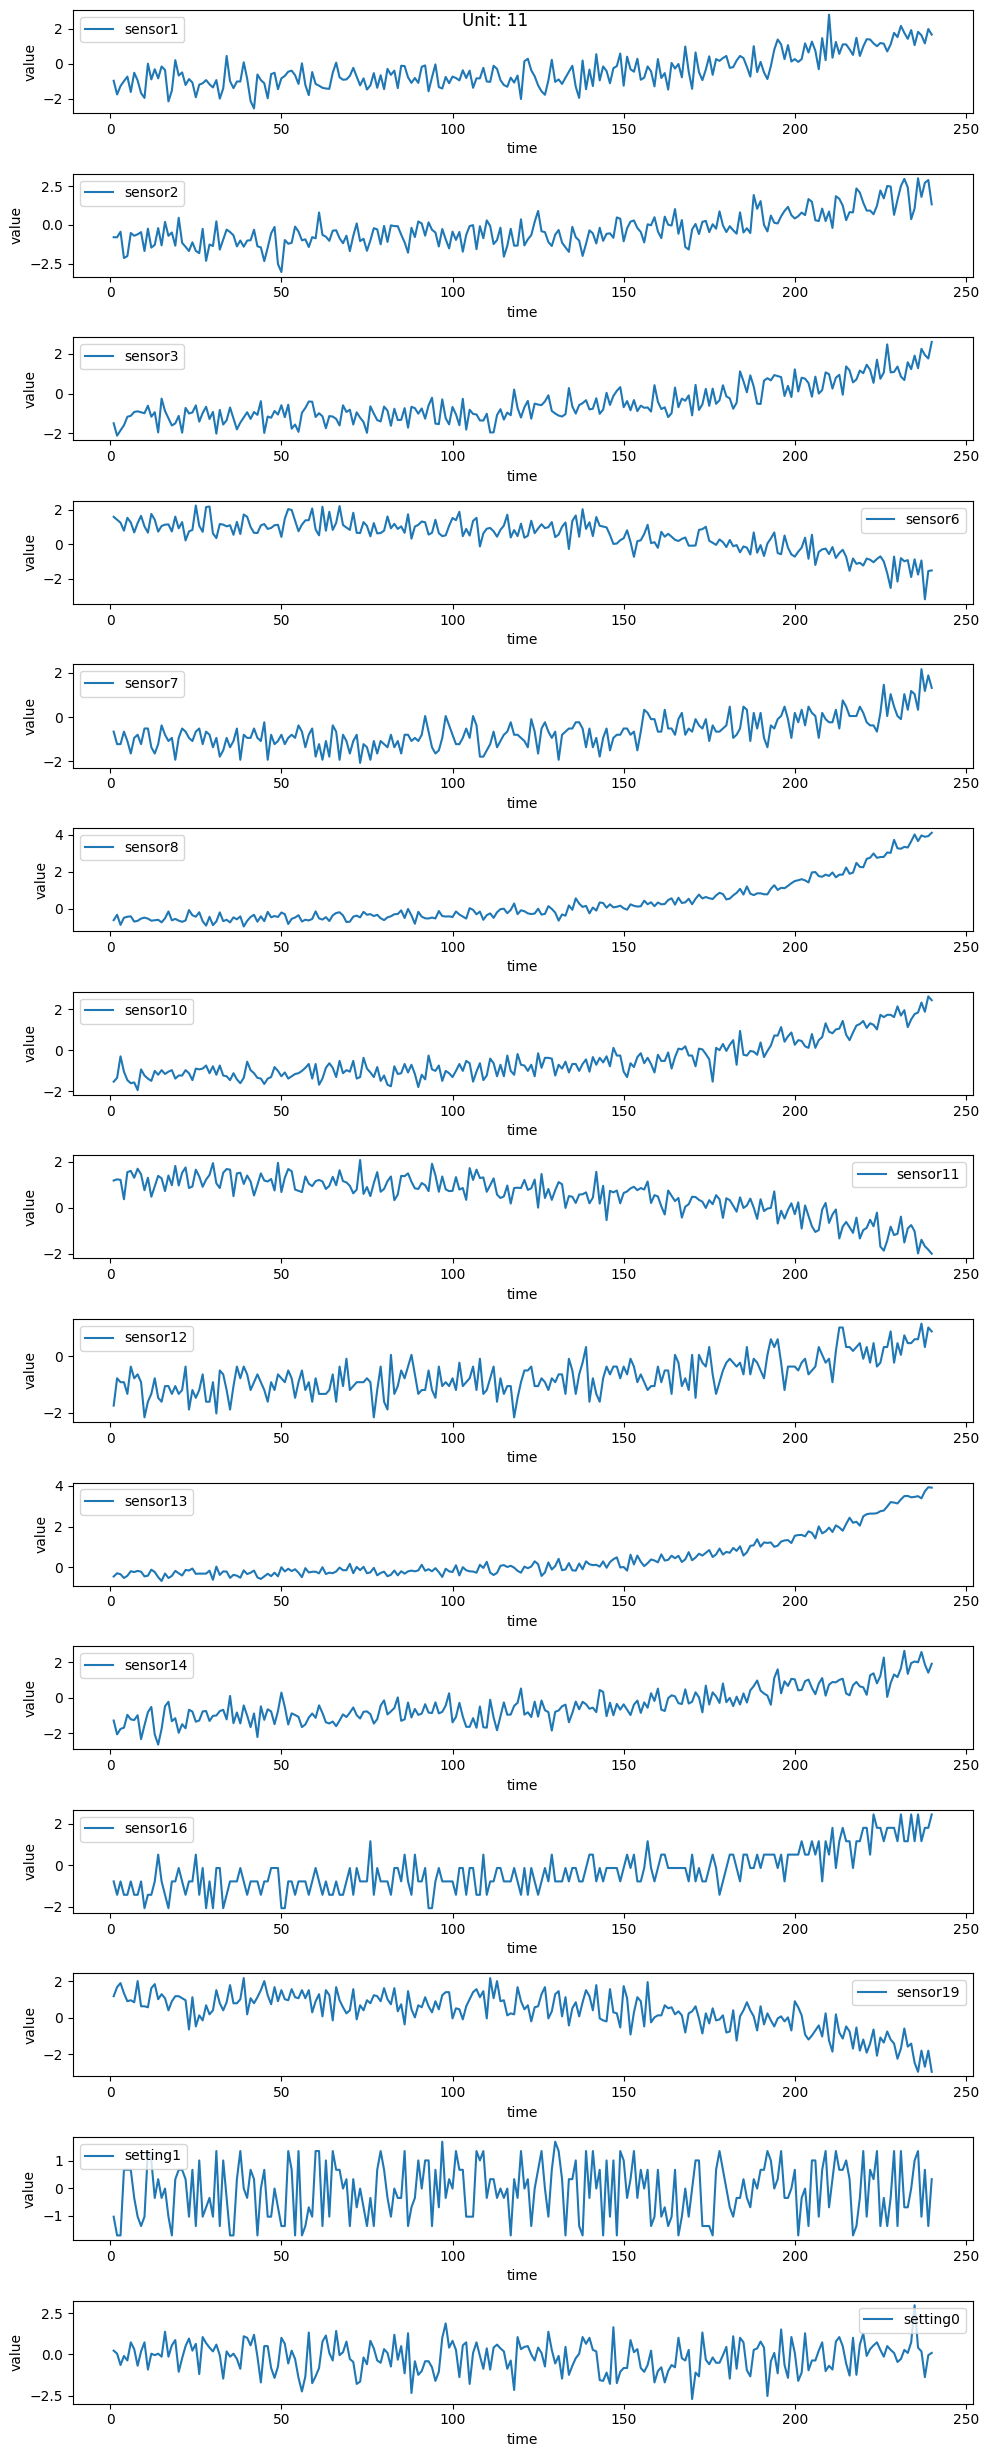

In [ ]:
#plot the input data for one unit
num_plot=13 #Plot for some sensors
fig, ax=plt.subplots(2+num_plot, figsize=(10,25))


unit_to_plot=11

for i, sensor in enumerate([1,2,3,6,7,8,10,11,12,13,14,16,19,20][:num_plot]):
  data_train_scaled[data_train_scaled["unit"]==unit_to_plot].plot("time", f"sensor{sensor}", ax=ax[i], label=f"sensor{sensor}", ylabel="value")

data_train_scaled[data_train_scaled["unit"]==unit_to_plot].plot("time", "setting1", ax=ax[-2], label=f"setting1", ylabel="value")
data_train_scaled[data_train_scaled["unit"]==unit_to_plot].plot("time", "setting0", ax=ax[-1], label=f"setting0", ylabel="value")
fig.suptitle(f"Unit: {unit_to_plot}")
fig.tight_layout()

In [ ]:
data_train_scaled.shape

(20631, 18)

## Note
All graphs have mean close to 0 and std close to 1. Normalization is done over all data over all units, but since the data of one unit is similar to that of the other units, the mean and std are similar. If we instead plotted one sensor for all units in one graph this graph would have exactly mean 0 and std 1.

## 8) Preparing the labels for the training data

In [5]:
#calculate the RUL per time step (labels for training)
# you don't have to touch this

data_numpy = np.genfromtxt('train_FD001.txt')

engine_time = []

for i in range(len(data_numpy)):
  if data_numpy[i, 0] != data_numpy[i-1, 0]:
      time_steps_data = []
      engine_time.append(time_steps_data)
  time_steps_data.append(data_numpy[i, 1])

engine_RUL = []

for i in range(len(engine_time)):
  rul_new_data = np.array(engine_time[i])
  engine_RUL += list(np.flip(rul_new_data))

label_train = pd.DataFrame(engine_RUL)
label_train.columns = ['RUL']

print(label_train.shape)

(20631, 1)


##9) Plot cycle time and RUL for all units

In [6]:
label_train = pd.concat([data_train_scaled[["unit", "time"]], label_train["RUL"]], axis=1)
label_train.head()

,unit,time,RUL
0,1,1,192.0
1,1,2,191.0
2,1,3,190.0
3,1,4,189.0
4,1,5,188.0


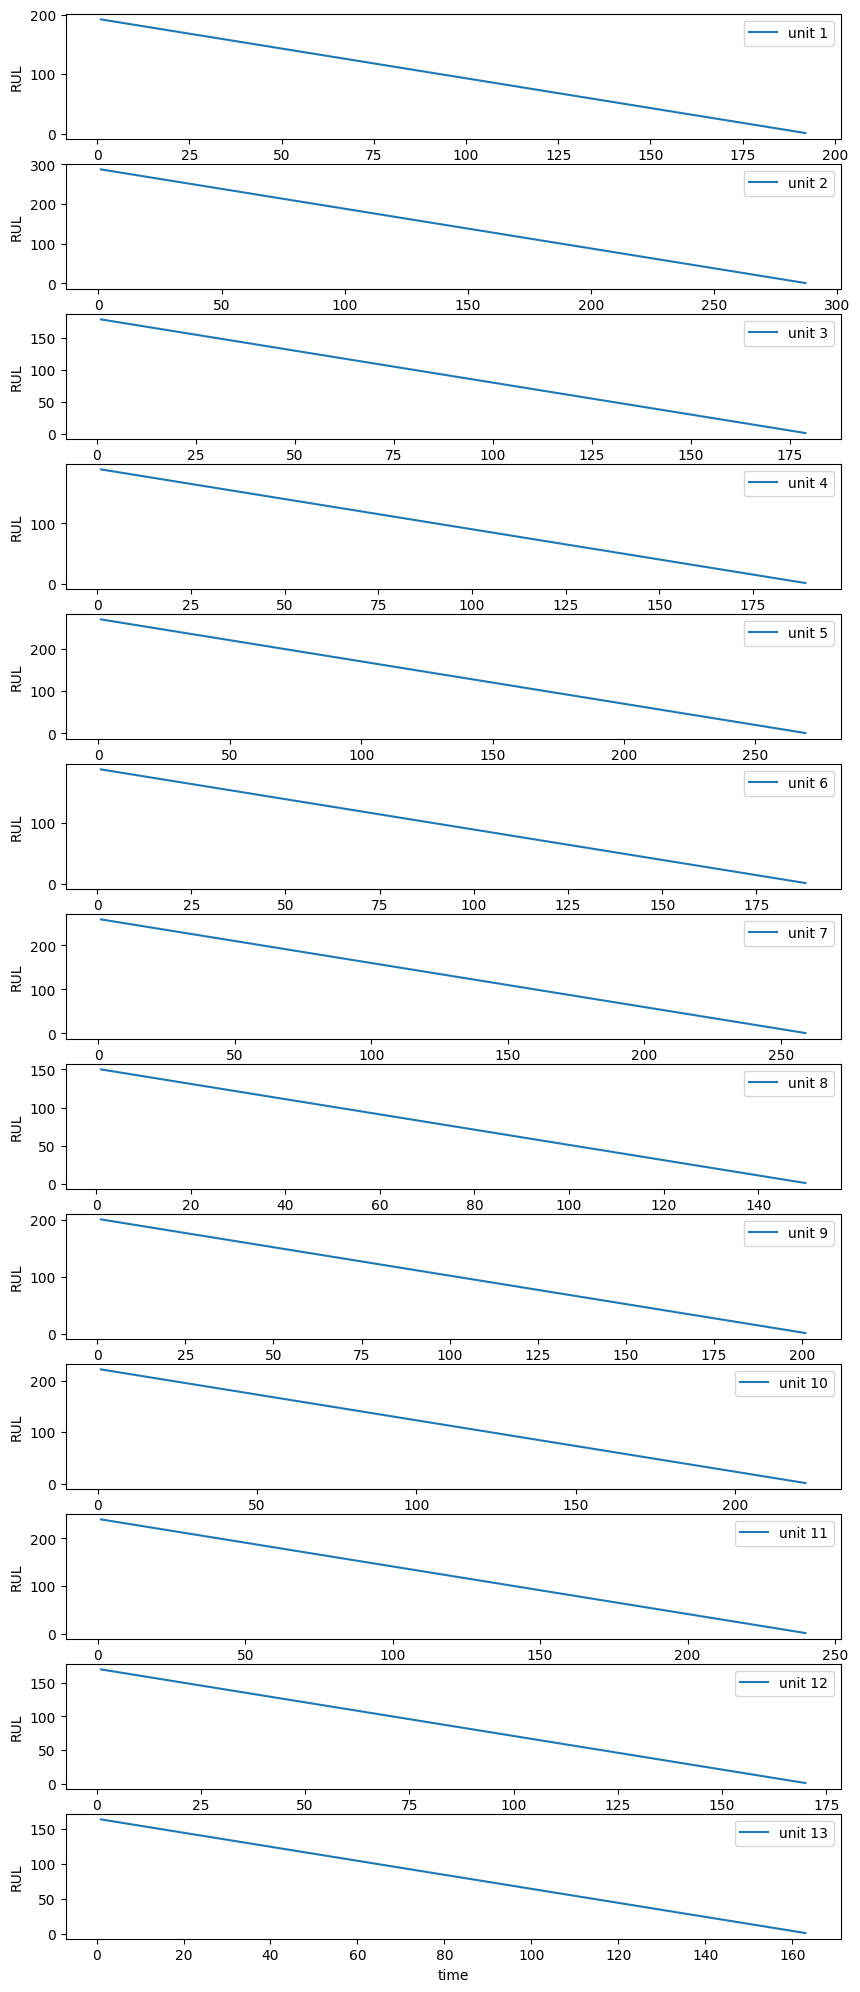

In [ ]:
#plot the labels of the training data set
num_plot=13 #Plot for some units
fig, ax=plt.subplots(num_plot, figsize=(10,25))

for unit in range(1,num_plot+1):
  label_train[label_train["unit"]==unit].plot("time", "RUL", ax=ax[unit-1], label=f"unit {unit}", ylabel="RUL", xlabel="time")

## 10) Creating time series samples

In [7]:
#Split up data for every unit to avoid mixup between timesteps of different units
#Unit column is not needed and index=time, also drop these columns
#Also convert into ndarray because the given code is written for numpy
data_train_scaled_split=[np.array(y.drop(["unit","time"], axis=1)) for x,y in data_train_scaled.groupby("unit")]
label_train_split=[np.array(y.drop(["unit","time"], axis=1)) for x,y in label_train.groupby("unit")]


In [9]:
print(len(data_train_scaled_split))
print(np.shape(data_train_scaled_split[0]))
print(np.shape(data_train_scaled_split[1]))
print(len(label_train_split))
print(np.shape(label_train_split[0]))
print(np.shape(label_train_split[1]))

100
(192, 16)
(287, 16)
100
(192, 1)
(287, 1)


In [8]:
#creating time series samples with length n_past to predict the RUL n_future steps in the future

trainX = []
trainY = []

n_future = 1
n_past =30

for unit_index in range(len(data_train_scaled_split)):
  unit_data=data_train_scaled_split[unit_index]
  unit_label=label_train_split[unit_index]
  for i in range(n_past, len(unit_data) - n_future +1):
    trainX.append(unit_data[i - n_past:i, 0:unit_data.shape[1]])
    trainY.append(unit_label[i + n_future - 1:i + n_future])

trainX_all, trainY_all = np.array(trainX), np.array(trainY)[:,0]

print('trainX shape == {}.'.format(trainX_all.shape))
print('trainY shape == {}.'.format(trainY_all.shape))

trainX shape == (17631, 30, 16).
trainY shape == (17631, 1).


## Note
In the loop ``i`` corresponds to the final time where the system is known. For each such time we append to ``trainX`` a sequence of length ``n_past`` which ends at ``i``. We don't consider ``i``s before the the time ``n_past`` so that the sequences always have the same length. For each ``i`` we also add to ``trainY`` the value of the system at time ``i+n_future``. So if we look at a element in ``trainX`` we will find a sequence of values of length ``n_past`` and on the corresponding element in ``trainY`` we will find the value at time ``n_future`` after the sequence ends. (And by time I mean number of time-steps). Also note that I added an outer loop in order to do this for every unit in the training set, so that we dont mix up time steps between units.

As for n_past I think this exercise is a bit ambigous for what my restriction is. From the structure of the given code it appears that it wants me to only train on sequences of a fixed length. In that case I would like this fixed length to be similar to the length of the sequences in the application of the model. So I would like n_past to be close to the number of seconds an engine has been running before NASA asks me to predict RUL. So what is this value? I assume that

In the end we get 17631 time samples with length 30 (n_past) and 16 sensor readings at each time, and the y vector contains the RUL at time decided by n_future for each series.

## 11) Preparing the test data

In [9]:
#test data set without labels

data_test = pd.read_csv('test_FD001.txt', delimiter=' ', header=None)

name_list = ['unit', 'time', 'setting0', 'setting1', 'setting2']
for i in range(number_of_sensors):
  name_list.append('sensor'+str(i))
name_list.append('empty1')
name_list.append('empty2')
data_test.columns = name_list

data_test = data_test.drop(['empty1'], axis=1)
data_test = data_test.drop(['empty2'], axis=1)

#drop the unneccesary columns
#Drop columns with no correlation to result
data_test=data_test.drop(["setting2", "sensor0", "sensor4", "sensor5", "sensor9", "sensor15", "sensor17", "sensor18"], axis=1)

#normalization of the test, don't normalize time and unit!
data_test_scaled=data_test.drop(["unit", "time"], axis=1)
#Use the scaler defined by the training set
data_test_scaled = pd.DataFrame(scaler.transform(data_test_scaled))

#Readd "unit"
data_test_scaled=pd.concat([data_test[["unit"]], data_test_scaled], axis=1)

#For each unit, create a time series (instead of the hard-to-read loop in the given code)
num_units=data_test_scaled["unit"].nunique()
data_test_list = [data_test_scaled[data_test_scaled["unit"]==unit].drop(["unit"], axis=1) for unit in range(1,num_units+1)]



print('data_test_list length == {}.'.format(len(data_test_list)))
print('data_test_list first element shape == {}.'.format(data_test_list[1].shape))

data_test_list length == 100.
data_test_list first element shape == (49, 16).


## 12) Preparing the labels for the test data

In [10]:
#test labels at the end of the series of each unit
# you don't have to touch this

label_test = pd.read_csv('RUL_FD001.txt', delimiter=' ', header=None)

name_list = ['RUL_final', 'empty']
label_test.columns = name_list
label_test = label_test.drop(['empty'], axis=1)

label_test_array = np.array(label_test)[:,0]

print('label_test shape == {}.'.format(label_test.shape))
print('label_test_array shape == {}.'.format(label_test_array.shape))

label_test shape == (100, 1).
label_test_array shape == (100,).


## Note
So for the test data I have choosen to make one sample for every unit. This is because the labels are structured in that way and it is explicitly written that I should not touch that part of the code.

## 13) Define the RNN

In [21]:
#Define the LSTM architecture

#Feed one time step with 16 values at a time
#I could change "None" to "n_past" in this case, but it is unclear from
#the excercise if I should construct a model which can predict from any sequence length
#or if my model should only be valid on sequences of equal length n_past
z0=layers.Input(shape=[None, 16])
#A number of hidden LSTM layers
z=layers.LSTM(32)(z0)

#Some dense layers
z=layers.Dense(16, activation="relu")(z)
#Reduce to one output which is the RUL of this unit at n_future
z=layers.Dense(1, activation="linear")(z)
#Why not use reLU here?
model = models.Model(inputs=z0, outputs=z)

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,817 (26.63 KB)

 Trainable params: 6,817 (26.63 KB)

 Non-trainable params: 0 (0.00 B)

## (Note:)
So I thought that since in this case the regression task is restricted to only positive values (assuming RUL is non-negative), I should use reLU activation instead of linear on the final layer. I asked chatGPT and he told me this was a bad idea, is he right about that?

## 14) Train the RNN

In [22]:
#Define callbacks to save the best model during the training

#Options for EarlyStopping, ReduceLROnPlateau and ModelCheckpoint
c1=keras.callbacks.ReduceLROnPlateau(factor=0.67, patience=3, verbose=1, min_lr=1e-5),
c2=keras.callbacks.EarlyStopping(patience=4, verbose=1)
c3=keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
c4=keras.callbacks.CSVLogger("history_{}.csv".format(model.name))

#Note that this will scramble the data before training
results = model.fit(trainX_all, trainY_all ,
    epochs=20,
    batch_size=200,
    verbose=1,
    validation_split=0.2,
    shuffle=True,
    callbacks=[c1,c2,c3, c4])

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 11517.1064 - val_loss: 14586.3545 - learning_rate: 0.0010
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9838.3975 - val_loss: 12273.1270 - learning_rate: 0.0010
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7827.8887 - val_loss: 10096.8857 - learning_rate: 0.0010
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5976.6626 - val_loss: 8071.6611 - learning_rate: 0.0010
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4453.9932 - val_loss: 6366.8296 - learning_rate: 0.0010
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3331.5676 - val_loss: 5036.8584 - learning_rate: 0.0010
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2513.6514 - val_loss: 4077.1753 - learning_rate: 0.0010
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1962.0060 - val_loss: 3424.4583 - learning_rate: 0.0010
Epoch 9/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1572.0795 - val_loss: 3005

## 15) Plot the results and Evaluate the performance

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'loss')]

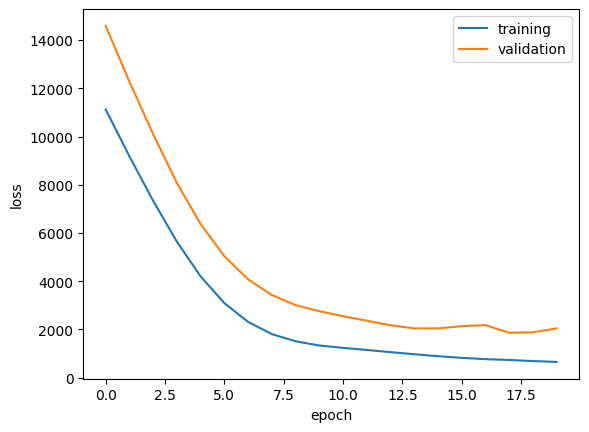

In [23]:
#Plotting training loss and validation loss
history = np.genfromtxt(f"history_{model.name}.csv", delimiter=",", names=True)

fig, ax = plt.subplots(1)
ax.plot(history["epoch"], history["loss"], label="training")
ax.plot(history["epoch"], history["val_loss"], label="validation")
ax.legend()
ax.set(xlabel="epoch", ylabel="loss")

In [26]:
#Testing on the training set to predict the RUL
#Predict only on 600
model.load_weights("best_model.keras")
num_predict=600
predictions=np.zeros(num_predict)
for i in range(num_predict):
  predictions[i]=model.predict(trainX_all[i:i+1,:,:], verbose=0)

<ipython-input-26-ccea54af1c09>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions[i]=model.predict(trainX_all[i:i+1,:,:], verbose=0)


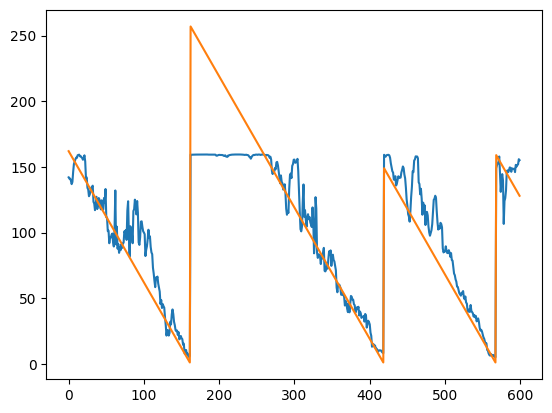

In [27]:
#Plotting the true RUL and the network prediction for the training data set
plt.plot(predictions)
plt.plot(trainY_all[:num_predict])

## Note:
Every spike shows that we predict for a new unit. Generally it follows the RUL curve but has an issue for example in the begginning of unit 2, seems that it is reluctant to guess RUL more than 160.

In [ ]:
#Testing on the n_past last samples of the test set to predict the RUL
num_test_units=label_test_array.shape[0]
test_pre
for unit in label_test_array.shape[0]:


In [ ]:
#Plotting the prediction and the true values for each unit
#Hint: It's easier to compare the true values and the predicted values if you order them in a smart way.

In [ ]:
#calculate the MSE of the two arrays

##16) Recommend Maintenance

In [ ]:
#Plotting the residuals in a histogram and determine the standard diviation

In [ ]:
#answer to question 10:

output_for_maint =
print('The engine should be recomended for maintainance with an output below: ', )